# Extracción de los ganadores a mejor pelicula internacional 

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
driver = webdriver.Chrome()

In [109]:
driver.get("https://es.wikipedia.org/wiki/Anexo:Ganadores_y_nominados_del_%C3%93scar_a_la_mejor_pel%C3%ADcula_internacional#1947-1949")

# Inicializar la lista para las tablas
tables = []

# Generar los XPaths y recoger las tablas
for i in range(3, 11):  # Ajustado a 10 para incluir la tabla 9
    xpath = f"/html/body/div[2]/div/div[3]/main/div[3]/div[3]/div[1]/table[{i}]"
    table = driver.find_element(By.XPATH, xpath)
    tables.append(table)

# Inicializar una lista para almacenar los datos
oscars_data = []

In [ ]:
for table in tables:
    rows = table.find_elements(By.TAG_NAME, 'tr')
    inicio = 1
    fin = len(rows) 
    print(fin)
    salto = 5

    for i in range(inicio, fin, salto):
        cells = rows[i].find_elements(By.TAG_NAME, 'td')
        print(len(cells))
        año = cells[0].find_element(By.TAG_NAME, 'a').text
        titulo = cells[1].text
        
        link = cells[1].find_element(By.TAG_NAME, 'a').get_attribute('href')
        titulo_original = cells[2].text
        pais = cells[3].text
        director = cells[4].text
        idioma = cells[5].text
        
        print(titulo)
        
        oscars_data.append([año, titulo, titulo_original, pais, director, idioma, link])
        

# Crear un DataFrame con los datos
df = pd.DataFrame(oscars_data, columns=['Año', 'Título', 'Título original', 'País', 'Director', 'Idioma', 'Link'])



In [114]:
# pasar a csv
df.to_csv('oscars_2.csv', index=False)

# Extracción de sinopsis de las peliculas

In [ ]:
Ruta = 'oscars_2.csv'
df = pd.read_csv(Ruta)
links = df['Link']
links

In [ ]:
def get_paragraph_text(url):
    """Function to retrieve the text of the first <p> element following the first <h2>."""
    driver.get(url)
    try:
        # Adjusted XPath to use a more robust relative path approach
        p = driver.find_element(By.XPATH, "/html/body/div[2]/div/div[3]/main/div[3]/div[3]/div[1]/h2[1]/following-sibling::p[1]")
        print(url)
        print(p.text)
        return p.text
    except NoSuchElementException:
        return None  # Return None if no paragraph is found

# Apply the function to each URL in the 'Link' column of the DataFrame
df['Paragraph_Text'] = df['Link'].apply(get_paragraph_text)


In [ ]:
df

# Limpieza de Datos - general

In [121]:
df.isnull().sum()

Año                0
Título             0
Título original    0
País               0
Director           0
Idioma             0
Link               0
Paragraph_Text     6
dtype: int64

Se llenan las sinopsis no encontradas con datos de https://www.filmaffinity.com/

1. Data frame con las sinopsis de las peliculas no encontradas

# TF-IDF: Representar las sinopsis

Recordemos que:

- **TF (Term Frequency)** mide la frecuencia con la que aparece una palabra en un documento. Si una palabra aparece muchas veces en un documento, se considera importante dentro de ese documento.
- **IDF (Inverse Document Frequency**) disminuye el peso de las palabras que aparecen muy frecuentemente en la colección de documentos y aumenta el peso de las palabras que son raras.

## Limpieza de datos

In [1]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:

import pandas as pd
df= pd.read_csv('oscars_sfinal.csv', sep=';')

In [3]:
df = df.rename(columns={'Paragraph_Text': 'Sinopsis'})

In [ ]:
%pip install spacy
%pip install unidecode
%pip install es_core_news_sm

# instal pip install -U spacy pydantic
#brew install openssl



In [4]:
import spacy
from unidecode import unidecode
from typing import Type

# Carga el modelo en español de spaCy
nlp = spacy.load('es_core_news_sm')

# Lista de palabras adicionales para considerar como stopwords
stop_words_extra = ['algún', 'alguna', 'algunos', 'algunas', 'aquel', 'aquella', 'aquellos', 'aquellas', 'mío', 'mía', 'él']

# Normalizar y añadir las palabras adicionales a las stopwords de spaCy
normalized_stop_words_extra = set(unidecode(sw) for sw in stop_words_extra)
for stopword in normalized_stop_words_extra:
    nlp.vocab[stopword].is_stop = True

def lematizar_texto(texto):
    # Procesa el texto con spaCy
    doc = nlp(texto)
    # Extrae los lemas de cada token en el documento, comprobando si son stopwords o alfabéticos
    lemas = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and not unidecode(token.lemma_) in normalized_stop_words_extra]
    # Reconstruye el texto procesado
    texto_procesado = ' '.join(lemas)
    return texto_procesado

# Aplicación de la función a la columna de sinopsis del DataFrame
df['sinopsis_limpia'] = df['Sinopsis'].apply(lematizar_texto)


## Calibrar vectorizador

### PCA

In [272]:
from sklearn.decomposition import PCA
import numpy as np

# Configurar el vectorizador TF-IDF con parámetros específicos
vectores = TfidfVectorizer(max_df=0.8, max_features=80, stop_words=['él', 'película', 'hacer', 'cine', 'cuyo'])

# Aplicar el vectorizador a tus datos y convertir la matriz a una matriz densa
matriz_tfidf = vectores.fit_transform(df['sinopsis_limpia']).toarray()

# Obtener nombres de características
nombres = vectores.get_feature_names_out()

# Ajustar PCA a la matriz TF-IDF
pca = PCA(n_components=3).fit(matriz_tfidf)

# Definir función para mostrar los tópicos y las palabras clave asociadas
def display_topics(feature_names, model, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Tópico %d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 8

display_topics(nombres, pca, no_top_words)

Tópico 0:
historia comenzar celebrar amor hombre momento desarrollar regresar
Tópico 1:
nazi mundial guerra historia judío vida alemania desarrollar
Tópico 2:
grupo encontrar llamado amante matrimonio volver soldado lugar


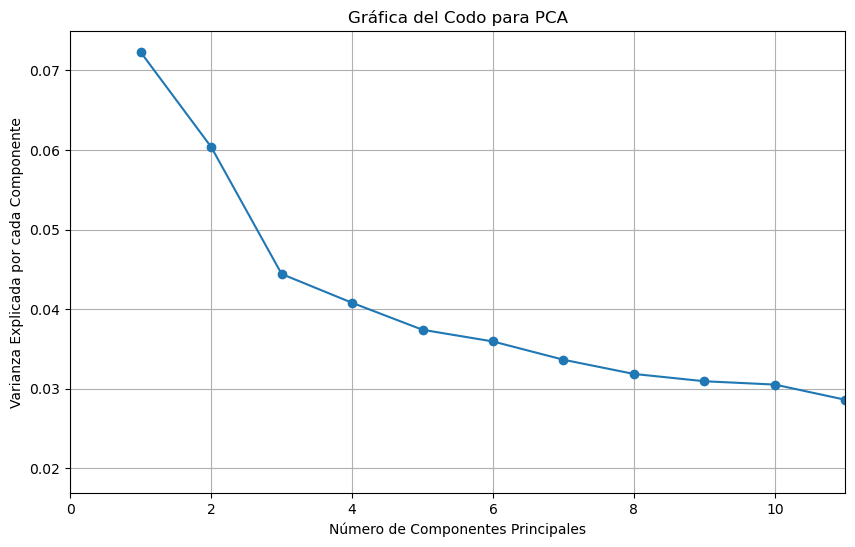

In [271]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Suponiendo que tienes un DataFrame 'df' y una columna de texto 'sinopsis_limpia'
vectores = TfidfVectorizer(max_df=0.8, max_features=80, stop_words=['él', 'película', 'hacer', 'cine', 'cuyo'])
matriz_tfidf = vectores.fit_transform(df['sinopsis_limpia']).toarray()


n_components = np.arange(1, 21)  
varianza_individual = []

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(matriz_tfidf)
    # Añadimos solo la varianza explicada por el último componente añadido
    varianza_individual.append(pca.explained_variance_ratio_[-1])

# Gráfica de la curva del codo
plt.figure(figsize=(10, 6))
plt.plot(n_components, varianza_individual, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada por cada Componente')
plt.title('Gráfica del Codo para PCA')
plt.grid(True)
plt.xlim(0, 11)  # Ajusta el rango del eje x según el número de componentes
plt.show()


### NMF

In [23]:
 %pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 7.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 7.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 8.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

miramos el numero de palabras totales

In [7]:
df['sinopsis_limpia'].str.split().str.len().sum()

2944

In [8]:
vectorizador_tfidf = TfidfVectorizer(max_df=0.90,min_df=0.1 ,max_features=1000)
matriz_tfidf = vectorizador_tfidf.fit_transform(df['sinopsis_limpia'])

- max_df: Ignora los términos que tienen una frecuencia de documento más alta que el valor dado.
- min_df: Ignora los términos que tienen una frecuencia de documento más baja que el valor dado.
- max_features: Establece el número máximo de términos que serán considerados, los cuales son los más frecuentes.

(índice del documento, indice del término) ->  Peso TF-IDF para el término correspondiente en ese documento.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# Configurar el vectorizador TF-IDF con parámetros específicos
#vectores = TfidfVectorizer(max_df=0.9 , min_df=0.1, max_features=40, stop_words=['él', 'película','hacer', 'cine', 'cuyo'])

vectores = TfidfVectorizer(max_df=0.9 , min_df=0.1, max_features=600, stop_words=['él', 'película','hacer', 'cine', 'cuyo'])


tfslimpio = vectores.fit_transform(df['sinopsis_limpia'])  # matriz TF-IDF

/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


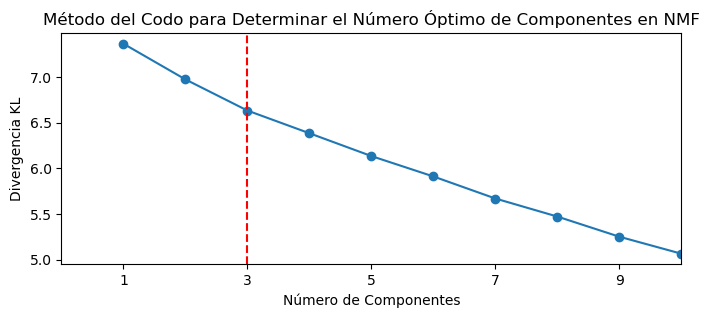

In [40]:
# Inertia es una medida de la calidad del clustering
inertia = []
# Prueba diferentes números de componentes
num_componentes = range(1, 11)

for k in num_componentes:
    # Entrenar el modelo NMF con el número de componentes actual
    nmf = NMF(n_components=k, random_state=1, l1_ratio=.5, init='nndsvd')
    nmf.fit(tfslimpio)
    # Añadir la inercia a la lista
    inertia.append(nmf.reconstruction_err_)

# Graficar la inercia en función del número de componentes
plt.figure(figsize=(8, 3))
plt.plot(num_componentes, inertia, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Divergencia KL')
plt.xticks(num_componentes)
plt.xlim(0, max(num_componentes))
plt.title('Método del Codo para Determinar el Número Óptimo de Componentes en NMF')
plt.axvline(x=3, color='red', linestyle='--')
plt.xticks(np.arange(1, 11, 2))
plt.show()


In [48]:
df_tfidf = pd.DataFrame(tfslimpio.toarray(), columns=vectores.get_feature_names_out()) # valores td idf x palabra 


nombreslimpio = vectores.get_feature_names_out(30)

# Configurar y aplicar el modelo NMF a la matriz TF-IDF
nmflimpio = NMF(n_components=3, random_state=1, l1_ratio=.5, init='nndsvd').fit(tfslimpio)



# Función para mostrar los tópicos y las palabras clave asociadas
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Tópico %d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 8


display_topics(nmflimpio, nombreslimpio, no_top_words)


Tópico 0:
año padre casa joven vivir madre mujer hijo
Tópico 1:
historia comenzar muerte vida hija hombre familia ciudad
Tópico 2:
nazi mundial guerra vida judío pequeño trabajar familia


## Análisis de similitud

In [85]:
# top 5 peliculas más similares 
def top5_similares(pelicula, matriz, df):
    # Calcular la similitud coseno entre la película de referencia y todas las demás
    similitudes = cosine_similarity(matriz[pelicula], matriz).flatten()
    # Obtener los índices de las 5 películas más similares
    indices_similares = similitudes.argsort()[-6:-1][::-1]
    # Imprimir la película que se está analizando
    print(f"Movie being analyzed: {df.iloc[pelicula]['Título']}")
    # Imprimir el grado de similitud por cada tópico
    for i, indice in enumerate(indices_similares):
        print(f"Similarity for Top-{i+1}: {similitudes[indice]}")
    # Devolver los títulos de las películas más similares
    return df.iloc[indices_similares]['Título']



Movie being analyzed: A Fantastic Woman
Similarity for Top-1: 0.4937618662255424
Similarity for Top-2: 0.4850823916000829
Similarity for Top-3: 0.4621748789772514
Similarity for Top-4: 0.42389056909976636
Similarity for Top-5: 0.413276163220616


5            Through a Glass Darkly
8     Yesterday, Today and Tomorrow
60                     The Salesman
52                       Departures
65                     Drive My Car
Name: Título, dtype: object

In [79]:
def top5_similares_decada(pelicula, matriz, df):
    # Obtener el año de la película de referencia
    año = df.iloc[pelicula]['Año']
    # Filtrar las películas de la misma década
    peliculas_decada = df[(df['Año'] >= año - 5) & (df['Año'] <= año + 5)]
    # Calcular la similitud coseno entre la película de referencia y todas las demás de la misma década
    similitudes = cosine_similarity(matriz[pelicula], matriz[peliculas_decada.index]).flatten()
    # Obtener los índices de las 5 películas más similares
    indices_similares = similitudes.argsort()[-6:-1][::-1]
    # Imprimir los títulos de las películas más similares y su similitud
    titulo_referencia = df.iloc[pelicula]['Título']
    print(f"Película de referencia: {titulo_referencia}")
    for indice in indices_similares:
        titulo = peliculas_decada.iloc[indice]['Título']
        similitud = similitudes[indice]
        print(f"Película: {titulo}, Similitud: {similitud}")

# Obtener las películas más similares a la primera película en la misma década
top5_similares_decada(63, tfslimpio, df)

Película de referencia: Parasite
Película: Roma, Similitud: 0.5637332013421907
Película: The Zone of Interest, Similitud: 0.4704151144152372
Película: Son of Saul, Similitud: 0.26254132437917216
Película: A Fantastic Woman, Similitud: 0.2159837826727954
Película: The Salesman, Similitud: 0.14338092507041728


In [86]:
# Calculate the cosine similarity between all movies
similarity_scores = cosine_similarity(tfslimpio)

# Replace the diagonal of the similarity matrix with zeros
np.fill_diagonal(similarity_scores, 0)

# Find the indices of the 5 highest similarity scores
top_indices = np.unravel_index(np.argsort(similarity_scores, axis=None)[-5:], similarity_scores.shape)

# Print the indices and corresponding movie titles
for i in range(5):
    movie1 = df.iloc[top_indices[0][i]]['Título']
    movie2 = df.iloc[top_indices[1][i]]['Título']
    similarity = similarity_scores[top_indices[0][i], top_indices[1][i]]
    print(f"Movie 1: {movie1}, Movie 2: {movie2}, Similarity: {similarity}")


Movie 1: Life Is Beautiful, Movie 2: Z, Similarity: 0.7928376277013864
Movie 1: Ida, Movie 2: The Great Beauty, Similarity: 1.0
Movie 1: The Great Beauty, Movie 2: Ida, Similarity: 1.0
Movie 1: Babette's Feast, Movie 2: Crouching Tiger, Hidden Dragon, Similarity: 1.0
Movie 1: Crouching Tiger, Hidden Dragon, Movie 2: Babette's Feast, Similarity: 1.0


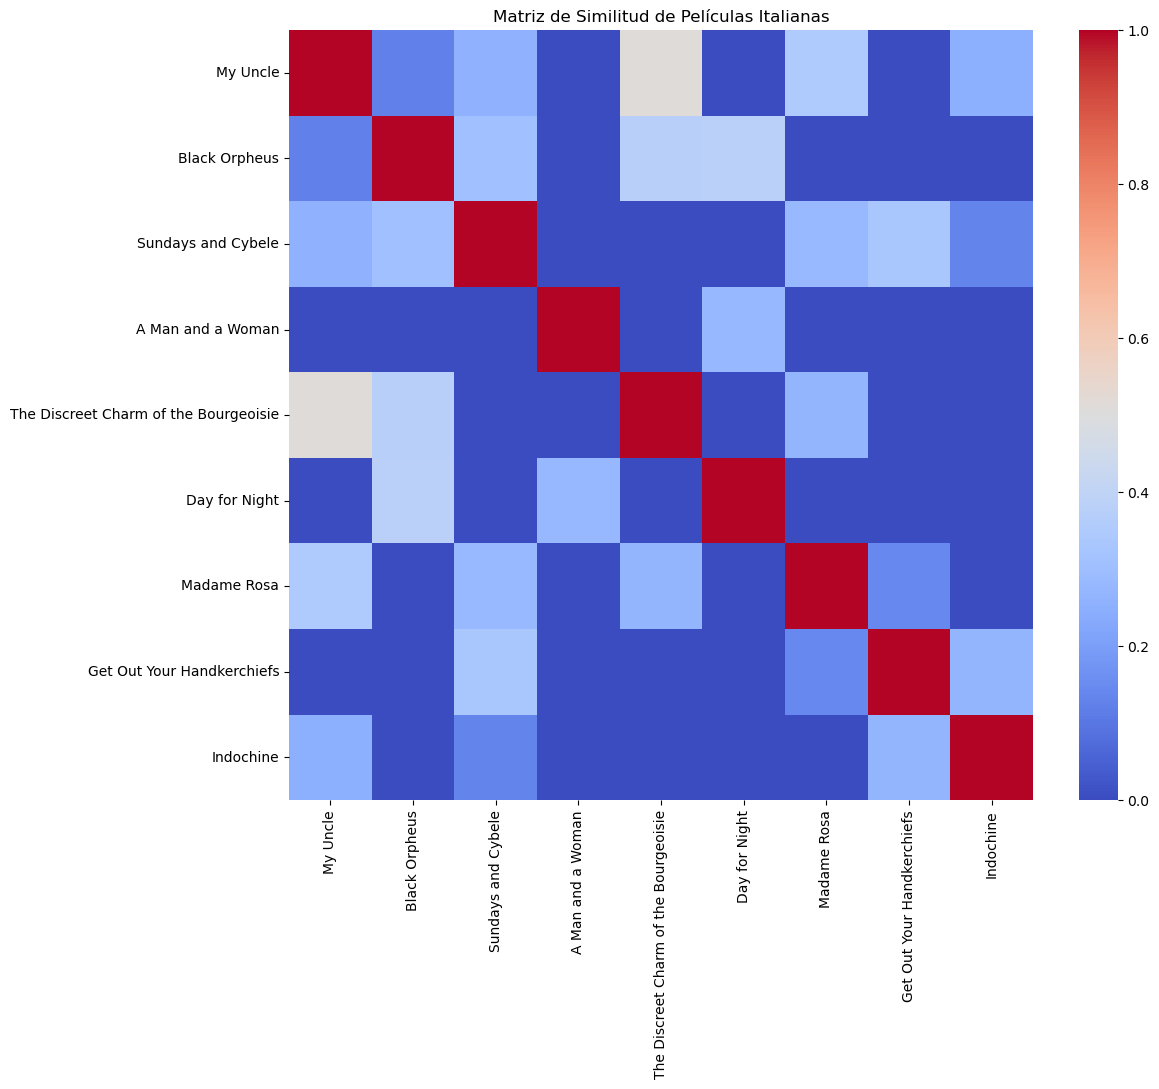

In [104]:
# filtra mi df por peliculas italianas
df_italia = df[df['País'] == 'Francia']

#grafica la matriz de similitud de las peliculas italianas
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(cosine_similarity(tfslimpio[df_italia.index]), cmap='coolwarm', xticklabels=df_italia['Título'], yticklabels=df_italia['Título'])
plt.title('Matriz de Similitud de Películas Italianas')
plt.show()


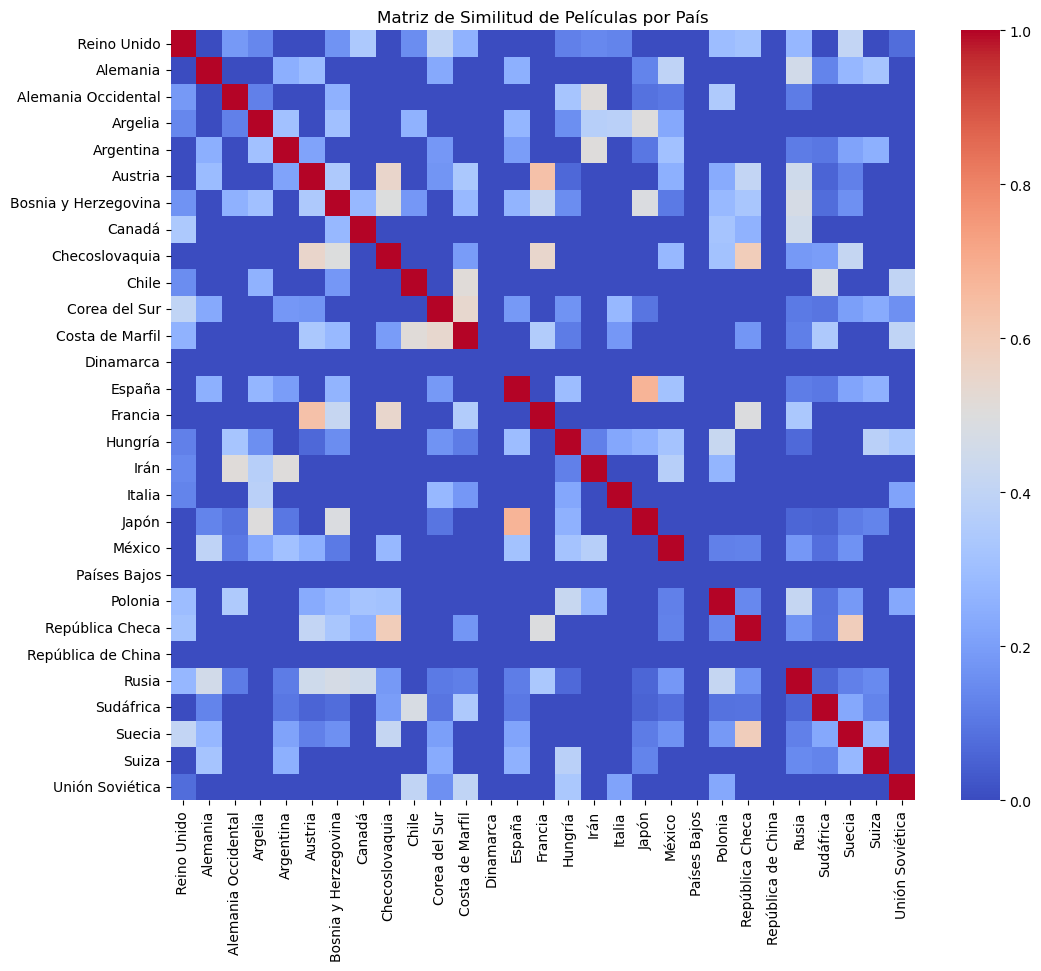

In [107]:
# haz un df agrupado por pais
df_pais = df.groupby('País').size().reset_index(name='Count')

# grafica la matriz de similitud de las peliculas por pais
plt.figure(figsize=(12, 10))
sns.heatmap(cosine_similarity(tfslimpio[df_pais.index]), cmap='coolwarm', xticklabels=df_pais['País'], yticklabels=df_pais['País'])
plt.title('Matriz de Similitud de Películas por País')
plt.show()

In [119]:
import plotly.express as px
import pandas as pd
import numpy as np

cargas_topico = nmflimpio.transform(tfslimpio)
# Supongamos que cargas_topico y df ya están definidos y cargados

# Extrayendo las coordenadas específicas para graficar y estandarizando
coordenadas_x = cargas_topico[:, 0]
coordenadas_y = cargas_topico[:, 2]

# Aplicar normalización Min-Max
def min_max_scaling(data, new_min=-1, new_max=1):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
    return scaled_data

coordenadas_x_scaled = min_max_scaling(coordenadas_x)
coordenadas_y_scaled = min_max_scaling(coordenadas_y)

# Crear un DataFrame
df_plot = pd.DataFrame({
    'X': coordenadas_x_scaled,
    'Y': coordenadas_y_scaled,
    'Título': df['Título'],
    'Año': df['Año']
})

# Asignar cuadrantes correctamente convirtiendo categorías a strings
x_cuts = pd.cut(df_plot['X'], bins=[-np.inf, 0, np.inf], labels=['Negativo', 'Positivo']).astype(str)
y_cuts = pd.cut(df_plot['Y'], bins=[-np.inf, 0, np.inf], labels=['Negativo', 'Positivo']).astype(str)
df_plot['Cuadrante'] = x_cuts + '-' + y_cuts

# Crear el gráfico de dispersión con Plotly, diferenciando por cuadrante
fig = px.scatter(df_plot, x='X', y='Y', color='Cuadrante', text='Título',
                 title='Similitud entre películas basada en tópicos de NMF por Cuadrantes',
                 labels={'X': 'Familia"', 'Y': 'Guerra'})
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=True)
fig.update_layout(showlegend=False, height=1200)  
fig.add_vline(x=0, line_width=2, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=2, line_dash="dash", line_color="black")

fig.show()

In [122]:
import plotly.express as px
import pandas as pd
import numpy as np

# Supongamos que cargas_topico y df ya están definidos y cargados

# Extrayendo las coordenadas específicas para graficar y estandarizando
coordenadas_x = cargas_topico[:, 0]
coordenadas_y = cargas_topico[:, 1]

# Aplicar normalización Min-Max
def min_max_scaling(data, new_min=-1, new_max=1):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
    return scaled_data

coordenadas_x_scaled = min_max_scaling(coordenadas_x)
coordenadas_y_scaled = min_max_scaling(coordenadas_y)

# Crear un DataFrame
df_plot = pd.DataFrame({
    'X': coordenadas_x_scaled,
    'Y': coordenadas_y_scaled,
    'Título': df['Título'],
    'Año': df['Año']
})

# Asignar cuadrantes correctamente convirtiendo categorías a strings
x_cuts = pd.cut(df_plot['X'], bins=[-np.inf, 0, np.inf], labels=['Negativo', 'Positivo']).astype(str)
y_cuts = pd.cut(df_plot['Y'], bins=[-np.inf, 0, np.inf], labels=['Negativo', 'Positivo']).astype(str)
df_plot['Cuadrante'] = x_cuts + '-' + y_cuts

# Crear el gráfico de dispersión con Plotly, diferenciando por cuadrante
fig = px.scatter(df_plot, x='X', y='Y', color='Cuadrante', text='Título',
                 title='Similitud entre películas basada en tópicos de NMF por Cuadrantes',
                 labels={'X': 'Familia"', 'Y': 'Ac. de vida'})
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=True)
fig.update_layout(showlegend=False, height=1200)  
fig.add_vline(x=0, line_width=2, line_dash="dash", line_color="black")
fig.add_hline(y=0, line_width=2, line_dash="dash", line_color="black")

fig.show()




In [18]:

cargas_topico = nmflimpio.transform(tfslimpio)

cargas_topico_0 = cargas_topico[:, 1]

# Obtener los índices de las 5 películas con mayor carga en el tópico 0
indices_top_5 = np.argsort(cargas_topico_0)[-5:]

# Obtener los nombres y las cargas de las 5 películas seleccionadas
titulos_top_5 = df['Título'].iloc[indices_top_5]
cargas_top_5 = cargas_topico_0[indices_top_5]

# Crear el gráfico de barras con Plotly
fig = px.bar(x=cargas_top_5, y=titulos_top_5, orientation='h', 
             labels={'x': 'Acontecimientos de vida', 'y': 'Título'}, 
             title='Top 5 Películas en el Tópico 1', 
             template='plotly_white')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(showlegend=True, height=500, width=1000)

fig.show()


In [19]:
indices_top_5 = np.argsort(cargas_topico_0)[-5:]

# Obtener los nombres y las cargas de las 5 películas seleccionadas
titulos_top_5 = df['Título'].iloc[indices_top_5]
cargas_top_5 = cargas_topico_0[indices_top_5]

# Crear el gráfico de barras con Plotly
fig = px.bar(x=cargas_top_5, y=titulos_top_5, orientation='h', 
             labels={'x': 'Puntaje del Tópico 0', 'y': 'Título'}, 
             title='Top 5 Películas en el Tópico 0', 
             template='plotly_white')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(showlegend=True, height=500, width=1000)

fig.show()


In [227]:
import plotly.express as px
import numpy as np

# Suponiendo que nmflimpio y tfslimpio ya están definidos y cargados

# Transformar los datos para obtener las cargas de los tópicos
cargas_topico = nmflimpio.transform(tfslimpio)

# Extraer las cargas para el tópico 0
cargas_topico_0 = cargas_topico[:, 2]

# Obtener los índices de las 5 películas con mayor carga en el tópico 0
indices_top_5 = np.argsort(cargas_topico_0)[-5:]

# Obtener los nombres y las cargas de las 5 películas seleccionadas
titulos_top_5 = df['Título'].iloc[indices_top_5]
cargas_top_5 = cargas_topico_0[indices_top_5]

# Crear el gráfico de barras con Plotly
fig = px.bar(x=cargas_top_5, y=titulos_top_5, orientation='h', 
             labels={'x': 'Puntaje del Tópico 0', 'y': 'Título'}, 
             title='Top 5 Películas en el Tópico 0', 
             template='plotly_white')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(showlegend=True, height=500, width=1000)
fig.show()


In [20]:
cargas_topico_0 = cargas_topico[:, 0]
cargas_topico_1 = cargas_topico[:, 1]
cargas_topico_2 = cargas_topico[:, 2]

In [27]:
import pandas as pd
import plotly.express as px

# Asumiendo que cargas_topico_0, cargas_topico_1, y cargas_topico_2 son arrays de numpy
# y que df es un DataFrame que ya existe y tiene una columna 'Año'

# Crear un DataFrame con las cargas de tópicos y los años
df_cargas = pd.DataFrame({
    'Año': df['Año'],
    'Familia': cargas_topico_0,
    'Guerra': cargas_topico_1,
    'A. Vida': cargas_topico_2
})

# Definir los bins desde 1950 hasta 2030 en incrementos de 10 años
bins = list(range(1950, 2031, 10))

# Etiquetas para las décadas, desde los 1950s hasta los 2020s
labels = [f'{decada}s' for decada in range(1950, 2030, 10)]

# Añadir una columna para la década, usando los bins y las etiquetas definidas
df_cargas['Década'] = pd.cut(df_cargas['Año'], bins=bins, labels=labels, right=False)

# Agrupar por década y calcular la media de las cargas de cada tópico
df_decadas = df_cargas.groupby('Década').mean().reset_index()

# Graficar las cargas de tópicos por década
fig = px.line(df_decadas, x='Década', y=['Familia', 'Guerra', 'A. Vida'], title='Carga de los Tópicos por Década',
              labels={'value': 'Carga del Tópico', 'variable': 'Tópico', 'Década': 'Década'},
              color_discrete_map={'Familia': 'blue', 'Guerra': 'red', 'A. Vida': 'green'},  # Asignación de colores
              markers=True)

fig.update_layout(xaxis_title='Década', yaxis_title='Carga del Tópico')
fig.update_layout(showlegend=True, height=500, width=800)

fig.show()



In [29]:
# top 5 paises con mas peliculas
top_5_paises = df['País'].value_counts().head(5)

# Obtener el índice del máximo y mínimo valor
max_index = top_5_paises.idxmax()
min_index = top_5_paises.idxmin()

# Crear una lista de colores para las barras
colors = ['lightgray'] * len(top_5_paises)
colors[top_5_paises.index.get_loc(max_index)] = 'green'


# Graficar con plotly
fig = px.bar(top_5_paises, x=top_5_paises.index, y=top_5_paises.values, title='Top 5 Países con más Premios Oscares',
             labels={'x': 'País', 'y': 'Número de Películas'}, template='plotly_white',
             color=colors, color_discrete_map={'lightgray': 'lightgray', 'green': 'green', 'red': 'red'})
fig.update_layout(showlegend=True, height=500, width=1000)
fig.show()



In [290]:
import pandas as pd
import plotly.express as px

# Suponiendo que cargas_topico_0, cargas_topico_1, y cargas_topico_2 son arrays con las cargas de cada tópico,
# y que 'df' es tu DataFrame original que contiene la columna 'País'.

# Crear un DataFrame con las cargas de tópicos y los países
df_cargas_pais = pd.DataFrame({
    'País': df['País'],
    'Familia': cargas_topico_0,  # Tópico relacionado con la familia
    'A.vida': cargas_topico_1,   # Tópico relacionado con la vida, posiblemente "aspectos de vida"
    'Guerra': cargas_topico_2    # Tópico relacionado con la guerra
})

# Agrupar por país y calcular la media de las cargas de cada tópico
df_promedio_pais = df_cargas_pais.groupby('País').mean().reset_index()

# Obtener los top 5 países con más películas
top_5_paises = df['País'].value_counts().head(5).index

# Filtrar el DataFrame para incluir solo los top 5 países
df_top_5_paises = df_promedio_pais[df_promedio_pais['País'].isin(top_5_paises)]

# Graficar las cargas de tópicos por país para los top 5 países
fig = px.bar(df_top_5_paises, x='País', y=['Familia', 'A.vida', 'Guerra'],
             title='Carga de los Tópicos por País',
             labels={'value': 'Carga del Tópico', 'variable': 'Tópico'},
             barmode='group', template='plotly_white',
             color_discrete_map={'Familia': 'blue', 'A.vida': 'green', 'Guerra': 'red'})

fig.update_layout(showlegend=True, legend_title_text='Tópicos', height=500, width=1000)
fig.show()


